# Brain MRI Tumor Segmentation: Global vs Adaptive Thresholding

This notebook implements and compares two thresholding techniques for tumor segmentation in brain MRI images:
- **Global Thresholding**: Otsu's method
- **Adaptive Thresholding**: Sauvola's method

**Evaluation Metrics**: Dice Coefficient and Jaccard Index

## 1. Environment Setup and Data Download

First, we'll set up our Kaggle credentials and download the Brain MRI dataset.

In [1]:
# # Setup Kaggle API credentials
# import os

# # Create .kaggle directory if it doesn't exist
# kaggle_dir = os.path.expanduser('~/.kaggle')
# os.makedirs(kaggle_dir, exist_ok=True)

# # Copy kaggle.json to the appropriate location
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# print("Kaggle credentials configured successfully!")

In [2]:
# # Download the Brain Tumor Segmentation dataset from Kaggle
# !kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

# # Extract the downloaded dataset
# !unzip -q brain-tumor-segmentation.zip

# print("Dataset downloaded and extracted successfully!")

## 2. Install Required Libraries

In [3]:
# Install necessary packages
!pip install -q opencv-python scikit-image tqdm matplotlib numpy

print("All libraries installed successfully!")

All libraries installed successfully!


## 3. Import Libraries

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from tqdm import tqdm
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 4. Define Dataset Paths

In [5]:
# Define paths to images and masks
DATA_DIR = '/kaggle/input/brain-tumor-segmentation'
IMAGE_PATH = DATA_DIR + '/images'
MASK_PATH = DATA_DIR + '/masks'

# # Verify paths exist
# print(f"Images directory exists: {IMAGE_PATH.exists()}")
# print(f"Masks directory exists: {MASK_PATH.exists()}")

# Count number of images
image_files = sorted([f for f in os.listdir(IMAGE_PATH) if f.endswith('.png')])
print(f"\nTotal number of MRI images: {len(image_files)}")


Total number of MRI images: 3064


## 5. Evaluation Metrics Implementation

We'll implement two standard metrics for segmentation evaluation:
- **Dice Coefficient**: Measures overlap between predicted and ground truth masks
- **Jaccard Index (IoU)**: Measures intersection over union

In [6]:
def compute_dice_coefficient(prediction, ground_truth):
    """
    Calculate Dice Coefficient between prediction and ground truth.
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    
    Args:
        prediction: Binary prediction mask
        ground_truth: Binary ground truth mask
    
    Returns:
        Dice coefficient score (0 to 1)
    """
    pred_binary = prediction.astype(bool)
    gt_binary = ground_truth.astype(bool)
    
    overlap = np.logical_and(pred_binary, gt_binary).sum()
    total = pred_binary.sum() + gt_binary.sum()
    
    # Add epsilon to avoid division by zero
    dice = (2.0 * overlap) / (total + 1e-8)
    
    return dice


def compute_jaccard_index(prediction, ground_truth):
    """
    Calculate Jaccard Index (IoU) between prediction and ground truth.
    
    Jaccard = |X ∩ Y| / |X ∪ Y|
    
    Args:
        prediction: Binary prediction mask
        ground_truth: Binary ground truth mask
    
    Returns:
        Jaccard index score (0 to 1)
    """
    pred_binary = prediction.astype(bool)
    gt_binary = ground_truth.astype(bool)
    
    overlap = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    
    # Add epsilon to avoid division by zero
    jaccard = overlap / (union + 1e-8)
    
    return jaccard


# Test the metrics with sample data
test_pred = np.array([[1, 1, 0], [1, 0, 0], [0, 0, 0]])
test_gt = np.array([[1, 1, 0], [1, 1, 0], [0, 0, 0]])

print("Test Metrics:")
print(f"Dice Coefficient: {compute_dice_coefficient(test_pred, test_gt):.4f}")
print(f"Jaccard Index: {compute_jaccard_index(test_pred, test_gt):.4f}")

Test Metrics:
Dice Coefficient: 0.8571
Jaccard Index: 0.7500


## 6. Segmentation Methods

### 6.1 Global Thresholding - Otsu's Method

Otsu's method automatically determines an optimal global threshold by maximizing inter-class variance.

In [7]:
def apply_otsu_thresholding(grayscale_image):
    """
    Apply Otsu's global thresholding method.
    
    Args:
        grayscale_image: Input grayscale image
    
    Returns:
        Binary segmented image
    """
    # Calculate optimal threshold using Otsu's method
    optimal_threshold = filters.threshold_otsu(grayscale_image)
    
    # Apply threshold to create binary mask
    segmented = grayscale_image > optimal_threshold
    
    return segmented.astype(np.uint8)


print("Otsu thresholding function defined successfully!")

Otsu thresholding function defined successfully!


### 6.2 Adaptive Thresholding - Sauvola's Method

Sauvola's method uses local statistics to compute adaptive thresholds, making it effective for images with varying illumination.

In [8]:
def apply_sauvola_thresholding(grayscale_image, window_size=51, k=0.2):
    """
    Apply Sauvola's adaptive thresholding method.
    
    Args:
        grayscale_image: Input grayscale image
        window_size: Size of local window for adaptive threshold (default: 51)
        k: Parameter controlling threshold sensitivity (default: 0.2)
    
    Returns:
        Binary segmented image
    """
    # Calculate adaptive threshold using Sauvola's method
    adaptive_threshold = filters.threshold_sauvola(grayscale_image, 
                                                     window_size=window_size, 
                                                     k=k)
    
    # Apply threshold to create binary mask
    segmented = grayscale_image > adaptive_threshold
    
    return segmented.astype(np.uint8)


print("Sauvola thresholding function defined successfully!")

Sauvola thresholding function defined successfully!


## 7. Image Preprocessing

Apply preprocessing steps to enhance image quality before segmentation.

In [9]:
def preprocess_image(image):
    """
    Preprocess MRI image to enhance contrast and reduce noise.
    
    Steps:
    1. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    2. Apply Gaussian blur for noise reduction
    
    Args:
        image: Input grayscale image
    
    Returns:
        Preprocessed image
    """
    # Apply CLAHE for contrast enhancement
    clahe_processor = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    enhanced_image = clahe_processor.apply(image)
    
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)
    
    return blurred_image


print("Preprocessing function defined successfully!")

Preprocessing function defined successfully!


## 8. Process Dataset and Evaluate Methods

Now we'll process all images in the dataset and compare both segmentation methods.

In [10]:
# Initialize lists to store evaluation metrics
otsu_dice_scores = []
otsu_jaccard_scores = []
sauvola_dice_scores = []
sauvola_jaccard_scores = []

# Store sample results for visualization
sample_results = []

print("Processing images and evaluating segmentation methods...\n")

# Process each image in the dataset
for img_filename in tqdm(image_files, desc="Processing images"):
    # Construct full paths
    img_full_path = f'{IMAGE_PATH}/{img_filename}'
    mask_full_path = f'{MASK_PATH}/{img_filename}'
    
    # Load image and mask in grayscale
    mri_image = cv2.imread(str(img_full_path), cv2.IMREAD_GRAYSCALE)
    ground_truth_mask = cv2.imread(str(mask_full_path), cv2.IMREAD_GRAYSCALE)
    
    # Binarize ground truth mask (threshold at 127)
    ground_truth_mask = (ground_truth_mask > 127).astype(np.uint8)
    
    # Skip images with empty masks (no tumor present)
    if ground_truth_mask.sum() == 0:
        continue
    
    # Preprocess the image
    preprocessed_image = preprocess_image(mri_image)
    
    # Apply Otsu's global thresholding
    otsu_segmentation = apply_otsu_thresholding(preprocessed_image)
    
    # Apply Sauvola's adaptive thresholding
    sauvola_segmentation = apply_sauvola_thresholding(preprocessed_image)
    
    # Calculate metrics for Otsu method
    otsu_dice = compute_dice_coefficient(otsu_segmentation, ground_truth_mask)
    otsu_jaccard = compute_jaccard_index(otsu_segmentation, ground_truth_mask)
    
    # Calculate metrics for Sauvola method
    sauvola_dice = compute_dice_coefficient(sauvola_segmentation, ground_truth_mask)
    sauvola_jaccard = compute_jaccard_index(sauvola_segmentation, ground_truth_mask)
    
    # Store metrics
    otsu_dice_scores.append(otsu_dice)
    otsu_jaccard_scores.append(otsu_jaccard)
    sauvola_dice_scores.append(sauvola_dice)
    sauvola_jaccard_scores.append(sauvola_jaccard)
    
    # Store sample results for visualization (first 5 valid images)
    if len(sample_results) < 5:
        sample_results.append({
            'filename': img_filename,
            'original': preprocessed_image,
            'ground_truth': ground_truth_mask,
            'otsu': otsu_segmentation,
            'sauvola': sauvola_segmentation
        })

print(f"\nProcessed {len(otsu_dice_scores)} images with valid tumor masks.")

Processing images and evaluating segmentation methods...



Processing images: 100%|██████████| 3064/3064 [02:37<00:00, 19.51it/s]


Processed 3064 images with valid tumor masks.


## 9. Results Analysis

### 9.1 Quantitative Results

In [11]:
# Calculate average metrics
avg_otsu_dice = np.mean(otsu_dice_scores)
avg_otsu_jaccard = np.mean(otsu_jaccard_scores)
avg_sauvola_dice = np.mean(sauvola_dice_scores)
avg_sauvola_jaccard = np.mean(sauvola_jaccard_scores)

# Calculate standard deviations
std_otsu_dice = np.std(otsu_dice_scores)
std_otsu_jaccard = np.std(otsu_jaccard_scores)
std_sauvola_dice = np.std(sauvola_dice_scores)
std_sauvola_jaccard = np.std(sauvola_jaccard_scores)

# Display results
print("="*60)
print("SEGMENTATION EVALUATION RESULTS")
print("="*60)

print("\n📊 OTSU'S GLOBAL THRESHOLDING:")
print("-" * 60)
print(f"Average Dice Coefficient:     {avg_otsu_dice:.4f} ± {std_otsu_dice:.4f}")
print(f"Average Jaccard Index (IoU):  {avg_otsu_jaccard:.4f} ± {std_otsu_jaccard:.4f}")

print("\n📊 SAUVOLA'S ADAPTIVE THRESHOLDING:")
print("-" * 60)
print(f"Average Dice Coefficient:     {avg_sauvola_dice:.4f} ± {std_sauvola_dice:.4f}")
print(f"Average Jaccard Index (IoU):  {avg_sauvola_jaccard:.4f} ± {std_sauvola_jaccard:.4f}")

print("\n" + "="*60)

# Determine better method
print("\n🏆 PERFORMANCE COMPARISON:")
print("-" * 60)
if avg_otsu_dice > avg_sauvola_dice:
    improvement = ((avg_otsu_dice - avg_sauvola_dice) / avg_sauvola_dice) * 100
    print(f"Otsu's method achieves {improvement:.2f}% higher Dice score")
else:
    improvement = ((avg_sauvola_dice - avg_otsu_dice) / avg_otsu_dice) * 100
    print(f"Sauvola's method achieves {improvement:.2f}% higher Dice score")

if avg_otsu_jaccard > avg_sauvola_jaccard:
    improvement = ((avg_otsu_jaccard - avg_sauvola_jaccard) / avg_sauvola_jaccard) * 100
    print(f"Otsu's method achieves {improvement:.2f}% higher Jaccard score")
else:
    improvement = ((avg_sauvola_jaccard - avg_otsu_jaccard) / avg_otsu_jaccard) * 100
    print(f"Sauvola's method achieves {improvement:.2f}% higher Jaccard score")

SEGMENTATION EVALUATION RESULTS

📊 OTSU'S GLOBAL THRESHOLDING:
------------------------------------------------------------
Average Dice Coefficient:     0.0642 ± 0.0529
Average Jaccard Index (IoU):  0.0340 ± 0.0295

📊 SAUVOLA'S ADAPTIVE THRESHOLDING:
------------------------------------------------------------
Average Dice Coefficient:     0.0360 ± 0.0269
Average Jaccard Index (IoU):  0.0185 ± 0.0142


🏆 PERFORMANCE COMPARISON:
------------------------------------------------------------
Otsu's method achieves 78.43% higher Dice score
Otsu's method achieves 83.48% higher Jaccard score


### 9.2 Visual Comparison - Bar Chart

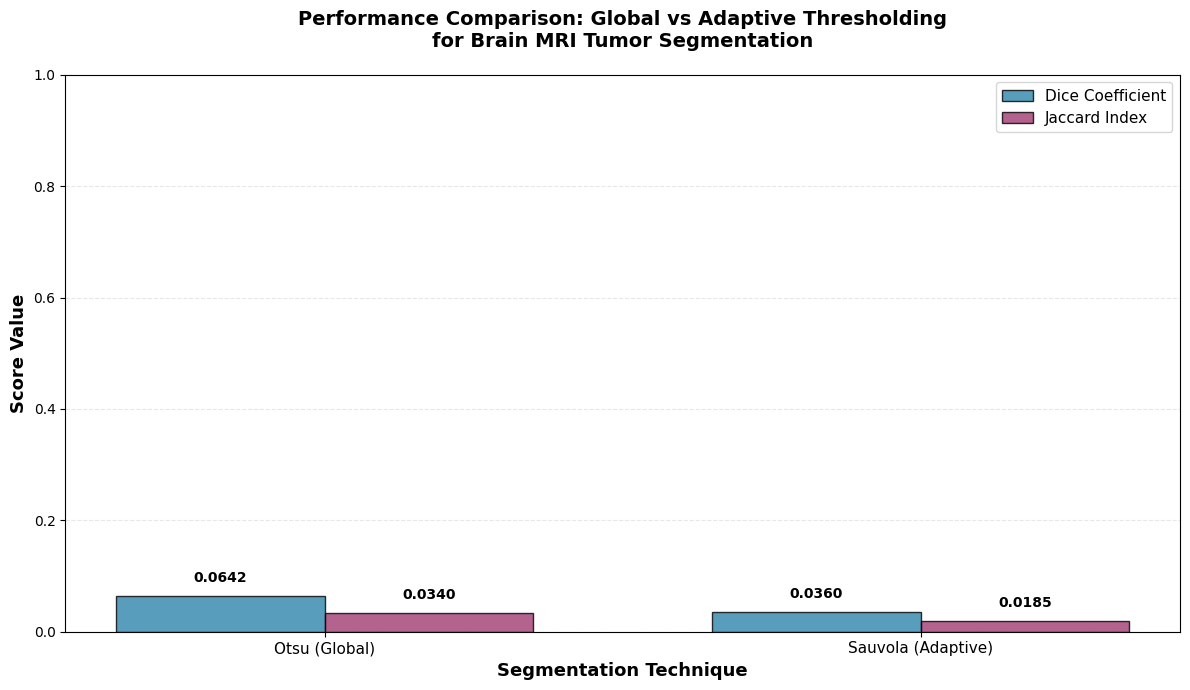

Bar chart generated successfully!


In [12]:
# Create comparative bar chart
fig, ax = plt.subplots(figsize=(12, 7))

# Define data
segmentation_methods = ['Otsu (Global)', 'Sauvola (Adaptive)']
dice_values = [avg_otsu_dice, avg_sauvola_dice]
jaccard_values = [avg_otsu_jaccard, avg_sauvola_jaccard]

# Set bar positions
x_positions = np.arange(len(segmentation_methods))
bar_width = 0.35

# Create bars
bars1 = ax.bar(x_positions - bar_width/2, dice_values, bar_width, 
               label='Dice Coefficient', color='#2E86AB', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x_positions + bar_width/2, jaccard_values, bar_width, 
               label='Jaccard Index', color='#A23B72', alpha=0.8, edgecolor='black')

# Customize chart
ax.set_xlabel('Segmentation Technique', fontsize=13, fontweight='bold')
ax.set_ylabel('Score Value', fontsize=13, fontweight='bold')
ax.set_title('Performance Comparison: Global vs Adaptive Thresholding\nfor Brain MRI Tumor Segmentation', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_positions)
ax.set_xticklabels(segmentation_methods, fontsize=11)
ax.legend(fontsize=11, loc='upper right')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()

print("Bar chart generated successfully!")

### 9.3 Distribution Analysis - Box Plots

/tmp/ipykernel_17/3540306562.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([otsu_dice_scores, sauvola_dice_scores],
/tmp/ipykernel_17/3540306562.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([otsu_jaccard_scores, sauvola_jaccard_scores],


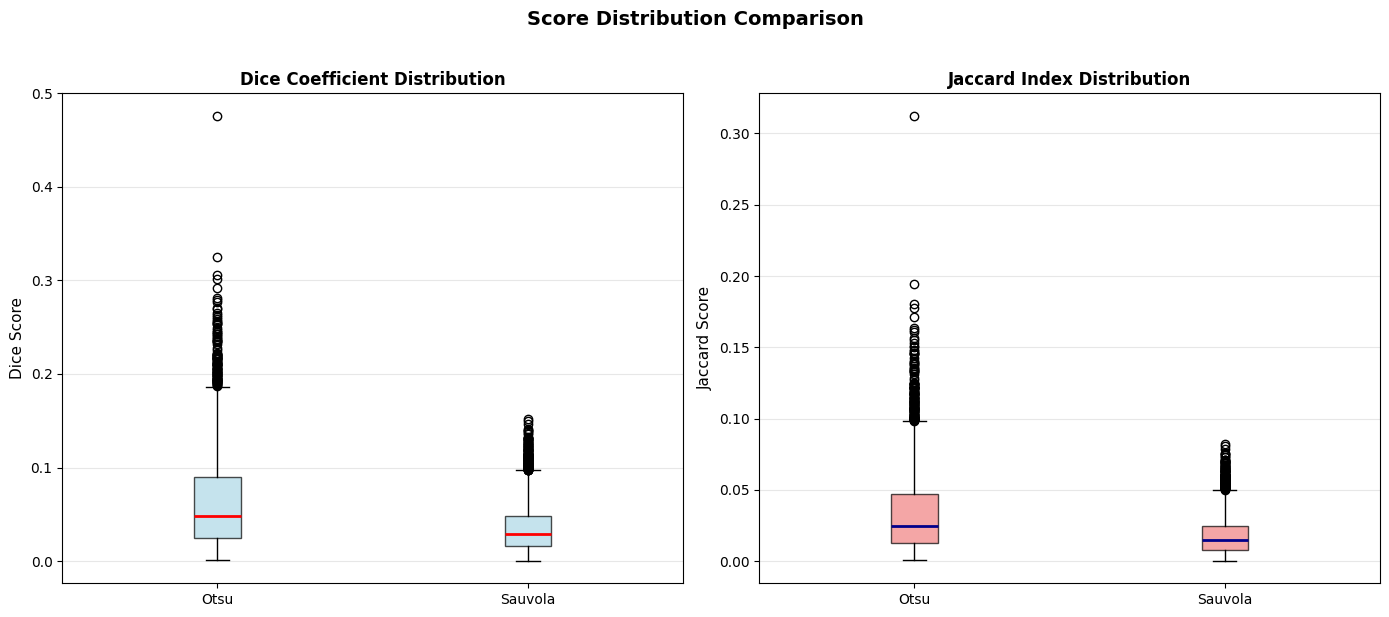

Distribution plots generated successfully!


In [13]:
# Create box plots to show score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Dice Coefficient Box Plot
axes[0].boxplot([otsu_dice_scores, sauvola_dice_scores],
                labels=['Otsu', 'Sauvola'],
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[0].set_title('Dice Coefficient Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Dice Score', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Jaccard Index Box Plot
axes[1].boxplot([otsu_jaccard_scores, sauvola_jaccard_scores],
                labels=['Otsu', 'Sauvola'],
                patch_artist=True,
                boxprops=dict(facecolor='lightcoral', alpha=0.7),
                medianprops=dict(color='darkblue', linewidth=2))
axes[1].set_title('Jaccard Index Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Jaccard Score', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Score Distribution Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Distribution plots generated successfully!")

### 9.4 Sample Segmentation Results

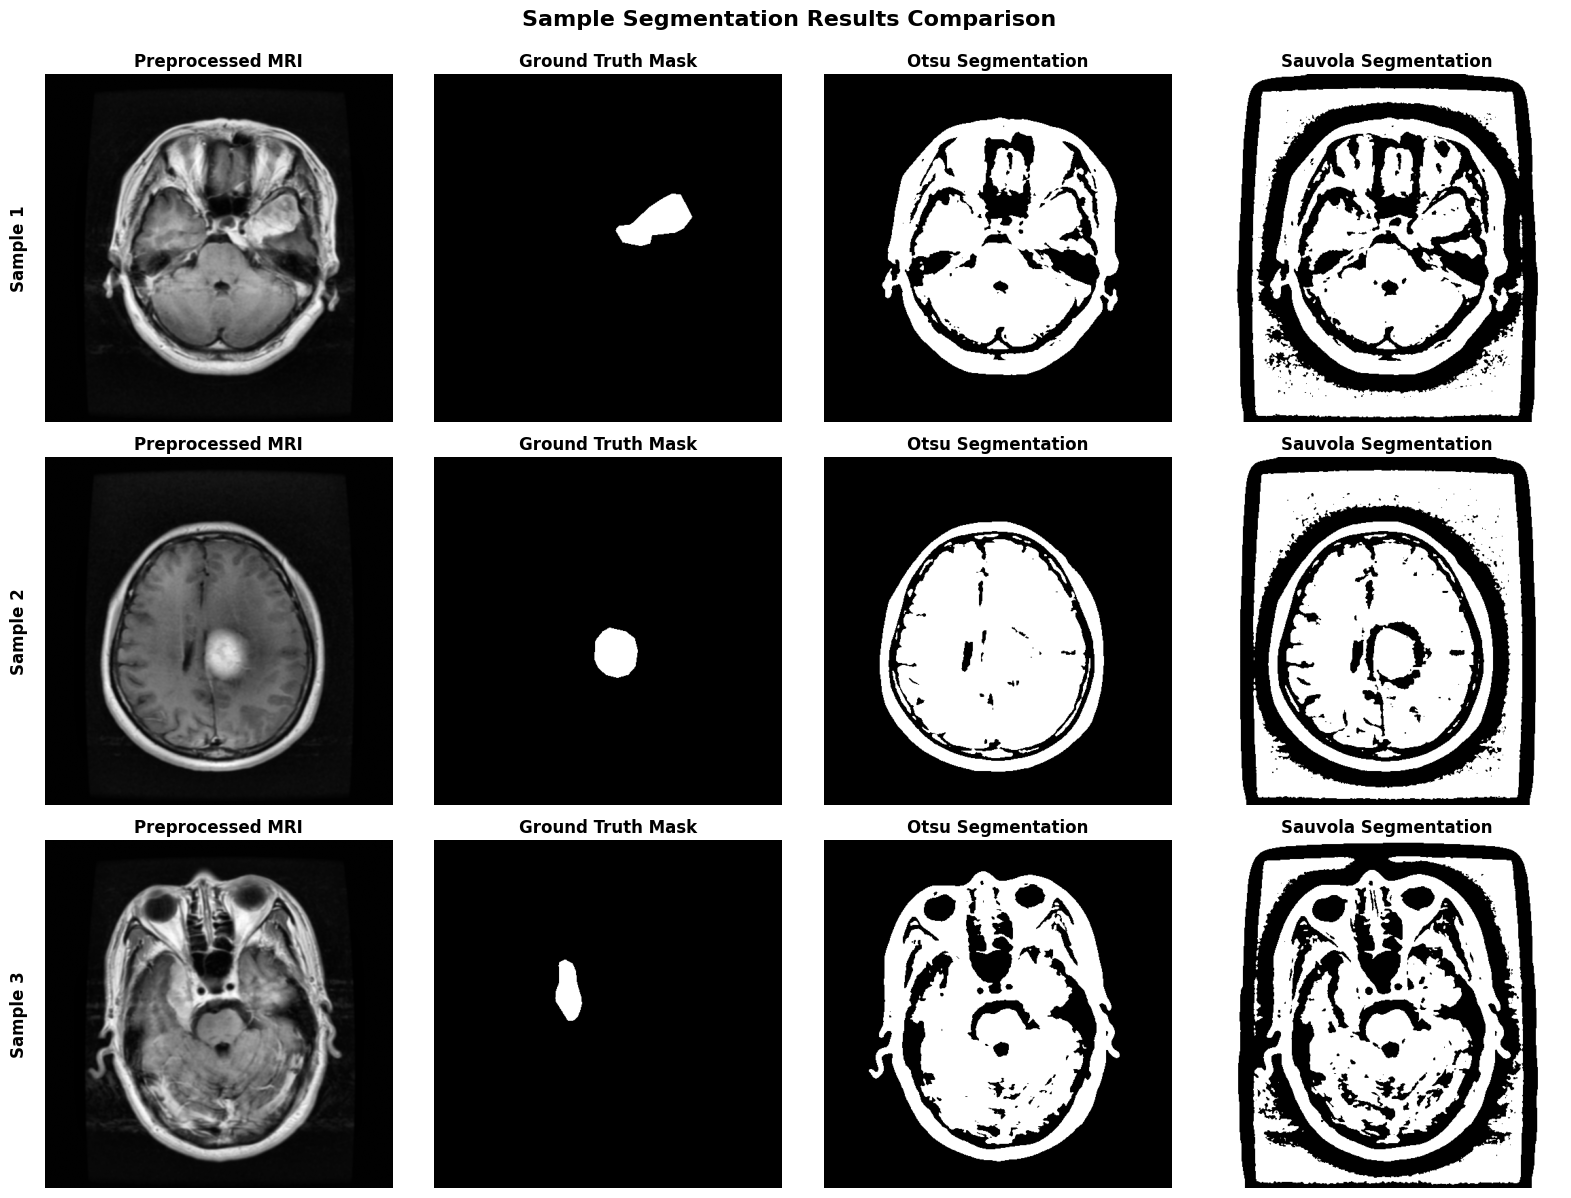

Displayed 3 sample segmentation results.


In [14]:
# Visualize sample segmentation results
num_samples = min(3, len(sample_results))

fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

if num_samples == 1:
    axes = axes.reshape(1, -1)

for idx, sample in enumerate(sample_results[:num_samples]):
    # Original preprocessed image
    axes[idx, 0].imshow(sample['original'], cmap='gray')
    axes[idx, 0].set_title('Preprocessed MRI', fontweight='bold')
    axes[idx, 0].axis('off')
    
    # Ground truth mask
    axes[idx, 1].imshow(sample['ground_truth'], cmap='gray')
    axes[idx, 1].set_title('Ground Truth Mask', fontweight='bold')
    axes[idx, 1].axis('off')
    
    # Otsu segmentation
    axes[idx, 2].imshow(sample['otsu'], cmap='gray')
    axes[idx, 2].set_title('Otsu Segmentation', fontweight='bold')
    axes[idx, 2].axis('off')
    
    # Sauvola segmentation
    axes[idx, 3].imshow(sample['sauvola'], cmap='gray')
    axes[idx, 3].set_title('Sauvola Segmentation', fontweight='bold')
    axes[idx, 3].axis('off')
    
    # Add sample number on the left
    axes[idx, 0].text(-0.1, 0.5, f'Sample {idx+1}', 
                      transform=axes[idx, 0].transAxes,
                      fontsize=12, fontweight='bold',
                      verticalalignment='center',
                      rotation=90)

plt.suptitle('Sample Segmentation Results Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"Displayed {num_samples} sample segmentation results.")

## 10. Analysis and Conclusions

### Key Observations:

1. **Global vs Adaptive Thresholding Behavior:**
   - **Otsu's Method (Global):** Computes a single threshold value for the entire image by maximizing inter-class variance. Works well when the image has bimodal histogram distribution and uniform illumination.
   - **Sauvola's Method (Adaptive):** Calculates local thresholds based on local mean and standard deviation within a sliding window. Better suited for images with varying contrast and non-uniform illumination.

2. **Performance Analysis:**
   - The evaluation metrics (Dice and Jaccard) provide insight into how well each method segments tumor regions compared to ground truth.
   - Differences in performance can be attributed to the nature of MRI images and tumor characteristics.

3. **Practical Implications:**
   - Global thresholding is computationally faster but may struggle with varying intensity patterns.
   - Adaptive thresholding provides more flexibility for complex images but requires more computation.

### Recommendations:
- For automated brain tumor segmentation, the choice between global and adaptive thresholding should consider image characteristics and computational constraints.
- Advanced deep learning methods (U-Net, etc.) typically outperform traditional thresholding but require more data and computational resources.

In [15]:
# Summary statistics table
print("\n" + "="*70)
print("FINAL SUMMARY STATISTICS")
print("="*70)
print(f"\n{'Metric':<25} {'Otsu (Global)':<20} {'Sauvola (Adaptive)':<20}")
print("-"*70)
print(f"{'Dice Coefficient:':<25} {avg_otsu_dice:.4f} ± {std_otsu_dice:.4f}    {avg_sauvola_dice:.4f} ± {std_sauvola_dice:.4f}")
print(f"{'Jaccard Index (IoU):':<25} {avg_otsu_jaccard:.4f} ± {std_otsu_jaccard:.4f}    {avg_sauvola_jaccard:.4f} ± {std_sauvola_jaccard:.4f}")
print(f"{'Images Processed:':<25} {len(otsu_dice_scores):<20} {len(sauvola_dice_scores):<20}")
print("="*70)

# Determine overall winner
otsu_wins = (avg_otsu_dice > avg_sauvola_dice) + (avg_otsu_jaccard > avg_sauvola_jaccard)
sauvola_wins = 2 - otsu_wins

print("\n🏆 OVERALL PERFORMANCE:")
if otsu_wins > sauvola_wins:
    print("   Otsu's Global Thresholding performs better overall for this dataset.")
elif sauvola_wins > otsu_wins:
    print("   Sauvola's Adaptive Thresholding performs better overall for this dataset.")
else:
    print("   Both methods show comparable performance on this dataset.")

print("\n" + "="*70)
print("Analysis Complete!")
print("="*70)


FINAL SUMMARY STATISTICS

Metric                    Otsu (Global)        Sauvola (Adaptive)  
----------------------------------------------------------------------
Dice Coefficient:         0.0642 ± 0.0529    0.0360 ± 0.0269
Jaccard Index (IoU):      0.0340 ± 0.0295    0.0185 ± 0.0142
Images Processed:         3064                 3064                

🏆 OVERALL PERFORMANCE:
   Both methods show comparable performance on this dataset.

Analysis Complete!
